In [1]:
## kernel: pyaudio27
import os
import numpy as np
import matplotlib.pyplot as plt
# https://github.com/librosa/librosa
import librosa
import librosa.display

from PIL import TiffImagePlugin
from PIL import Image
import tiffspect_v2

# Set some project parameters
K_SR = 22050
K_FFTSIZE = 1024 # also used for window length where that parameter is called for
K_HOP = 256
K_DUR = 5.0 # make all files this duration
K_FRAMEMULTIPLEOF = 4 # some programs like to have convinent dimensions for conv and decimation
                        # the last columns of a matrix are removed if necessary to satisfy
                        # 1 means any number of frames will work

# location of subdirectories of ogg files organized by category
K_OGGDIR = '/Volumes/BothWays/ZCODE/GitHubOthers/karoldvi_ESC-50/ESC-50/'
# location to write the wav files (converted from ogg)
K_WAVEDIR = 'esc50Wave'
# location to write the spectrogram files (converted from wave files)
K_SPECTDIR = 'esc50spect'

K_QSPECTDIR = 'esc50Qspect'

#K_WAVEDIR =  '/Volumes/Bothways/ZCODE/TENSORFLOW/dcn_soundclass/sounds'
#K_SPECTDIR = '/Volumes/Bothways/ZCODE/TENSORFLOW/dcn_soundclass/scratch/spectrograms'


In [2]:
def get_subdirs(a_dir):
    """ Returns a list of sub directory names in a_dir """ 
    return [name for name in os.listdir(a_dir)
            if (os.path.isdir(os.path.join(a_dir, name)) and not (name.startswith('.')))]

def listDirectory(directory, fileExtList):                                        
    """Returns list of file info objects in directory that extension in the list fileExtList - include the . in your extension string"""
    fnameList = [os.path.normcase(f)
                for f in os.listdir(directory)
                    if (not(f.startswith('.')))]            
    fileList = [os.path.join(directory, f) 
               for f in fnameList
                if os.path.splitext(f)[1] in fileExtList]  
    return fileList , fnameList

def dirs2labelfile(parentdir, labelfile):
    """takes subdirectories of parentdir and writes them, one per line, to labelfile"""
    namelist = get_subdirs(parentdir)
    with open(labelfile, mode='wt', encoding='utf-8') as myfile:
        myfile.write('\n'.join(namelist))

In [3]:
def stereo2mono(data) :
    """ Combine 2D array into a single array, averaging channels """ 
    """ Deprecated, since we use librosa for this now. """ 
    print('converting stereo data of shape ' + str(data.shape))
    outdata=np.ndarray(shape=(data.shape[0]), dtype=np.float32)
    if data.ndim != 2 :
        print('You are calling stero2mono on a non-2D array')
    else : 
        print('    converting stereo to mono, with outdata shape = ' + str(outdata.shape))
        for idx in range(data.shape[0]) :
            outdata[idx] = (data[idx,0]+data[idx,1])/2
    return outdata

In [4]:
# esc50Ogg2Wav('/Volumes/BothWays/ZCODE/GitHubOthers/karoldvi_ESC-50/ESC-50/', 'data', 5.0, K_SR)
def esc50Ogg2Wav (topdir, outdir, dur, srate) :
    """ 
        Creates regularlized wave files for the ogg files in the ESC-50 dataset. 
        Creates class folders for the wav files in outdir with the same structure found in topdir.
        
        Parameters
            topdir - the ESC-50 dir containing class folders. 
            outdir - the top level directory to write wave files to (written in to class subfolders)
            dur - (in seconds) all files will be truncated or zeropadded to have this duration given the srate
            srate - input files will be resampled to srate as they are read in before being saved as wav files
    """ 
    sample_length = int(dur * srate)
    try:
        os.stat(outdir)  # test for existence
    except:
        os.mkdir(outdir) # create if necessary
        
    subdirs = get_subdirs(topdir)
    for subdir in subdirs :
        try:
            os.stat(outdir + '/'  + subdir) # test for existence
        except:
            os.mkdir(outdir + '/' + subdir) # create if necessary
            print('creating ' + outdir + '/'  + subdir)
    
        fullpaths, _ = listDirectory(topdir + '/' + subdir, '.ogg') 
        for idx in range(len(fullpaths)) : 
            fname = os.path.basename(fullpaths[idx])
            # librosa.load resamples to sr, clips to duration, combines channels. 
            audiodata, samplerate = librosa.load(fullpaths[idx], sr=srate, mono=True, duration=dur) # resamples if necessary (some esc-50 files are in 48K)
            # just checking ..... 
            if (samplerate != srate) :
                print('You got a sound file ' + subdir  +  '/' +  fname + ' with sample rate ' + str(samplerate) + '!')
                print(' ********* BAD SAMPLE RATE ******** ')
            if (audiodata.ndim != 1) :
                print('You got a sound file ' + subdir  +  '/' +  fname + ' with ' + str(audiodata.ndim) + ' channels!')
                audiodata = stereo2mono(audiodata)
            if (len(audiodata) > sample_length) :
                print('You got a long sound file ' + subdir  +  '/' +  fname + ' with shape ' + str(audiodata.shape) + '!')
                audiodata = np.resize(audiodata, sample_length)
                # print('  ..... and len(audiodata) = ' + str(len(audiodata)) + ', while sample_length is sposed to be ' + str(sample_length))
                print('trimming data to shape ' + str(audiodata.shape))
            if (len(audiodata) < sample_length) :
                print('You got a short sound file ' + subdir  +  '/' +  fname + ' with shape ' + str(audiodata.shape) + '!')
                audiodata = np.concatenate([audiodata, np.zeros((sample_length-len(audiodata)))])
                print('      zero padding data to shape ' + str(audiodata.shape))
            # write the file out as a wave file
            librosa.output.write_wav(outdir + '/' + subdir + '/' + os.path.splitext(fname)[0] + '.wav', audiodata, samplerate)
        

## OK - do the conversion (just takes something like 5 minutes to run on the whole set)

#esc50Ogg2Wav(K_OGGDIR, K_WAVEDIR, K_DUR, K_SR)

In [6]:
#esc50Ogg2Wav(K_OGGDIR, K_WAVEDIR, K_DUR, K_SR)

You got a short sound file 201 - Rain/1-56311-A.ogg with shape (109952,)!
      zero padding data to shape (110250,)
You got a short sound file 201 - Rain/2-82367-A.ogg with shape (109888,)!
      zero padding data to shape (110250,)
You got a short sound file 202 - Sea waves/5-208810-A.ogg with shape (110016,)!
      zero padding data to shape (110250,)
You got a short sound file 203 - Crackling fire/2-65747-A.ogg with shape (109440,)!
      zero padding data to shape (110250,)
You got a short sound file 203 - Crackling fire/3-104632-A.ogg with shape (109600,)!
      zero padding data to shape (110250,)
You got a short sound file 203 - Crackling fire/4-164661-B.ogg with shape (80384,)!
      zero padding data to shape (110250,)
You got a short sound file 301 - Crying baby/2-107351-A.ogg with shape (109440,)!
      zero padding data to shape (110250,)
You got a short sound file 409 - Clock tick/5-208624-A.ogg with shape (109920,)!
      zero padding data to shape (110250,)
You got a sh

In [5]:
import scipy

def wav2spect(fname, srate, fftSize, fftHop, dur=None, showplt=False, dcbin=True, framesmulitpleof=1) :
    try:
        audiodata, samplerate = librosa.load(fname, sr=srate, mono=True, duration=dur) 
    except:
        print('can not read ' + fname)
        return
    
    S = np.abs(librosa.stft(audiodata, n_fft=fftSize, hop_length=fftHop, win_length=fftSize,  center=False))

    if (dcbin ==  False) :
        S = np.delete(S, (0), axis=0)  # delete freq 0 row
            #note: a pure DC input signal bleeds into bin 1, too.
    
    #trim the non-mulitple fat if necessary
    nr, nc = S.shape  
    fat = nc%framesmulitpleof
    for num in range(0,fat):
        S = np.delete(S, (nc-1-num), axis=1)
        
        
    D = librosa.amplitude_to_db(S, ref=np.max)
    
    if showplt : # Dangerous for long runs - it opens a new figure for each file!
        librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=srate, hop_length=fftHop)
        plt.colorbar(format='%+2.0f dB')
        plt.title(showplt)
        plt.show(block=True)
                
    return D

In [6]:
import scipy
%matplotlib inline

def esc50Wav2Spect(topdir, outdir, dur, srate, fftSize, fftHop, showplt=False, dcbin=True) :
    """ 
        Creates spectrograms for subfolder-labeled wavfiles. 
        Creates class folders for the spectrogram files in outdir with the same structure found in topdir.
        
        Parameters
            topdir - the dir containing class folders containing wav files. 
            outdir - the top level directory to write wave files to (written in to class subfolders)
            dur - (in seconds) all files will be truncated or zeropadded to have this duration given the srate
            srate - input files will be resampled to srate as they are read in before being saved as wav files
    """ 
    
    try:
        os.stat(outdir)  # test for existence
    except:
        os.mkdir(outdir) # create if necessary
    
    #for saving with the spectra files
    tiffinfo={"sr" : srate, "n_fft" : fftSize, "hop_length" : fftHop}
    
    subdirs = get_subdirs(topdir)
    count = 0
    for subdir in subdirs :
        try:
            os.stat(outdir + '/'  + subdir) # test for existence
        except:
            os.mkdir(outdir + '/' + subdir) # create if necessary
            print('creating ' + outdir + '/'  + subdir)
    
        fullpaths, _ = listDirectory(topdir + '/' + subdir, '.wav') 
        
        for idx in range(len(fullpaths)) : 
            fname = os.path.basename(fullpaths[idx])
            D = wav2spect(fullpaths[idx], srate, fftSize, fftHop, dur=dur, dcbin=True, showplt=False, framesmulitpleof=K_FRAMEMULTIPLEOF)
            
            #plt.title(str(count) + ':  ' + subdir + '/' + os.path.splitext(fname)[0]) 
            
            tiffspect_v2.logSpect2Tiff(D, outdir + '/' + subdir + '/' + os.path.splitext(fname)[0] + '.tif', tiffinfo)
            
            print(str(count) + ': ' + subdir + '/' + os.path.splitext(fname)[0])
            count +=1
            
 

## OK - do the conversion (actually runs faster than the ogg to wav conversion)

#esc50Wav2Spect(K_WAVEDIR, K_SPECTDIR, K_DUR, K_SR, K_FFTSIZE, K_HOP)


In [11]:
#esc50Wav2Spect(K_WAVEDIR, K_SPECTDIR, K_DUR, K_SR, K_FFTSIZE, K_HOP, dcbin=True) 

creating esc50spect/101 - Dog
0: 101 - Dog/1-100032-A
1: 101 - Dog/1-110389-A
2: 101 - Dog/1-30226-A
3: 101 - Dog/1-30344-A
4: 101 - Dog/1-32318-A
5: 101 - Dog/1-59513-A
6: 101 - Dog/1-85362-A
7: 101 - Dog/1-97392-A
8: 101 - Dog/2-114280-A
9: 101 - Dog/2-114587-A
10: 101 - Dog/2-116400-A
11: 101 - Dog/2-117271-A
12: 101 - Dog/2-118072-A
13: 101 - Dog/2-118964-A
14: 101 - Dog/2-122104-A
15: 101 - Dog/2-122104-B
16: 101 - Dog/3-136288-A
17: 101 - Dog/3-144028-A
18: 101 - Dog/3-155312-A
19: 101 - Dog/3-157695-A
20: 101 - Dog/3-163459-A
21: 101 - Dog/3-170015-A
22: 101 - Dog/3-180256-A
23: 101 - Dog/3-180977-A
24: 101 - Dog/4-182395-A
25: 101 - Dog/4-183992-A
26: 101 - Dog/4-184575-A
27: 101 - Dog/4-191687-A
28: 101 - Dog/4-192236-A
29: 101 - Dog/4-194754-A
30: 101 - Dog/4-199261-A
31: 101 - Dog/4-207124-A
32: 101 - Dog/5-203128-A
33: 101 - Dog/5-203128-B
34: 101 - Dog/5-208030-A
35: 101 - Dog/5-212454-A
36: 101 - Dog/5-213855-A
37: 101 - Dog/5-217158-A
38: 101 - Dog/5-231762-A
39: 101 - D

In [7]:
def logfmap(I,L,H) :
    """
    % [M,N] = logfmap(I,L,H)
    I - number of rows in the original spectrogram
    L - low bin to preserve
    H - high bin to preserver
    
    %     Return a maxtrix for premultiplying spectrograms to map
    %     the rows into a log frequency space.
    %     Output map covers bins L to H of input
    %     L must be larger than 1, since the lowest bin of the FFT
    %     (corresponding to 0 Hz) cannot be represented on a 
    %     log frequency axis.  Including bins close to 1 makes 
    %     the number of output rows exponentially larger.
    %     N returns the recovery matrix such that N*M is approximately I
    %     (for dimensions L to H).
    %     
    % Ported from MATLAB code written by Dan Ellis:
    % 2004-05-21 dpwe@ee.columbia.edu
    """
    ratio = (H-1)/H;
    opr = np.int(np.round(np.log(L/H)/np.log(ratio))) #number of frequency bins in log rep + 1
    print('opr is ' + str(opr))
    ibin = L*np.exp(list(range(0,opr)*-np.log(ratio)))  #fractional bin numbers (len(ibin) = opr-1)
    
    M = np.zeros((opr,I))
    eps=np.finfo(float).eps
    
    for i in range(0, opr) :
        # Where do we sample this output bin?
        # Idea is to make them 1:1 at top, and progressively denser below
        # i.e. i = max -> bin = topbin, i = max-1 -> bin = topbin-1, 
        # but general form is bin = A exp (i/B)

        tt = np.multiply(np.pi, (list(range(0,I))-ibin[i]))
        M[i,:] = np.divide(  (np.sin(tt)+eps) , (tt+eps));

    # Normalize rows, but only if they are boosted by the operation
    G = np.ones((I));
    print ('H is ' + str(H))
    G[0:H] = np.divide(list(range(0,H)), H)
    
    N = np.transpose(np.multiply(M,np.matlib.repmat(G,opr,1)))
                   
    return M, N


In [12]:
def esc50Spect2logFreqSpect(topdir, outdir, srate, fftSize, fftHop, lowRow=1) :
    """ 
        Creates psuedo constant-Q spectrograms from linear frequency spectrograms. 
        Creates class foldersfna in outdir with the same structure found in topdir.
        
        Parameters
            topdir - the dir containing class folders containing tif (log magnitude) spectrogram files. 
            outdir - the top level directory to write psuedo constantQ files to (written in to class subfolders)
            lowRow is the lowest row in the FFT that you want to include in the psuedo constant Q spectrogram
    """ 
    
    # First lets get the logf map we want
    LIN_FREQ_BINS=int(fftSize/2+1) #number of bins in original linear frequency mag spectrogram
    LOW_ROW=lowRow
    LOG_FREQ_BINS=int(fftSize/2+1) #resample the lgfmapped psuedo consantQ matrix to have this many frequency bins
    M,N = logfmap(LIN_FREQ_BINS,LOW_ROW,LOG_FREQ_BINS);

    
    try:
        os.stat(outdir)  # test for existence
    except:
        os.mkdir(outdir) # create if necessary
    
    subdirs = get_subdirs(topdir)
    count = 0
    for subdir in subdirs :
        try:
            os.stat(outdir + '/'  + subdir) # test for existence
        except:
            os.mkdir(outdir + '/' + subdir) # create if necessary
            print('creating ' + outdir + '/'  + subdir)
    
        fullpaths, _ = listDirectory(topdir + '/' + subdir, '.tif') 
        
        for idx in range(len(fullpaths)) : 
            fname = os.path.basename(fullpaths[idx])
            D, tiffinfo = tiffspect_v2.Tiff2LogSpect(fullpaths[idx])
            
                #print('tiffinfo is ' + str(tiffinfo))
            
            # Here's the beef
            MD = np.dot(M,D);
            # and down sample
            MD = scipy.signal.resample(MD, LIN_FREQ_BINS) #downsample to something reasonable 

            #save
            tiffinfo["linFreqBins"] =  LIN_FREQ_BINS
            tiffinfo["lowRow"] = LOW_ROW
            tiffinfo["logFreqBins"] = LOG_FREQ_BINS
            tiffspect_v2.logSpect2Tiff(D, outdir + '/' + subdir + '/' + os.path.splitext(fname)[0] + '.tif', tiffinfo)
            
            print(str(count) + ': ' + subdir + '/' + os.path.splitext(fname)[0])
            count +=1           

## OK - do the conversion (actually runs faster than the ogg to wav conversion)


In [13]:
#if you want the logfreq mapped spectrogram, do this next:
#esc50Spect2logFreqSpect(K_SPECTDIR, K_QSPECTDIR, K_SR, K_FFTSIZE, K_HOP, lowRow=10)


opr is 2018
H is 513
0: 101 - Dog/1-100032-A
1: 101 - Dog/1-110389-A
2: 101 - Dog/1-30226-A
3: 101 - Dog/1-30344-A
4: 101 - Dog/1-32318-A
5: 101 - Dog/1-59513-A
6: 101 - Dog/1-85362-A
7: 101 - Dog/1-97392-A
8: 101 - Dog/2-114280-A
9: 101 - Dog/2-114587-A
10: 101 - Dog/2-116400-A
11: 101 - Dog/2-117271-A
12: 101 - Dog/2-118072-A
13: 101 - Dog/2-118964-A
14: 101 - Dog/2-122104-A
15: 101 - Dog/2-122104-B
16: 101 - Dog/3-136288-A
17: 101 - Dog/3-144028-A
18: 101 - Dog/3-155312-A
19: 101 - Dog/3-157695-A
20: 101 - Dog/3-163459-A
21: 101 - Dog/3-170015-A
22: 101 - Dog/3-180256-A
23: 101 - Dog/3-180977-A
24: 101 - Dog/4-182395-A
25: 101 - Dog/4-183992-A
26: 101 - Dog/4-184575-A
27: 101 - Dog/4-191687-A
28: 101 - Dog/4-192236-A
29: 101 - Dog/4-194754-A
30: 101 - Dog/4-199261-A
31: 101 - Dog/4-207124-A
32: 101 - Dog/5-203128-A
33: 101 - Dog/5-203128-B
34: 101 - Dog/5-208030-A
35: 101 - Dog/5-212454-A
36: 101 - Dog/5-213855-A
37: 101 - Dog/5-217158-A
38: 101 - Dog/5-231762-A
39: 101 - Dog/5-9032

audiodata max is 0.772186, and audiodata sum is -21.1287
esc50Wav2Spect" magspec max is 24.7249, and magspec sum is 59889.3, and magspec min is 1.22432e-06
esc50Wav2Spect" Sfoo max is 24.7249, and Sfoo sum is 59552.2, and Sfoo min is 1.22432e-06
spectrogram D shape is (513, 427)
esc50Wav2Spect" ampDB max is 0.0, and ampDB min is -80.0


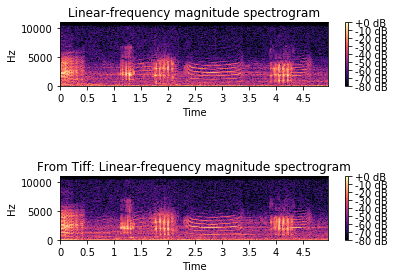

In [15]:
# example of using librosa spectrogram viewer as well as tiff file writer and reader
import scipy
%matplotlib inline

# Just run this on any wav file in your system.
audiodata, samplerate = librosa.load('esc50Wave/109 - Sheep/4-196671-B.wav', sr=K_SR, mono=True, duration=K_DUR) # resamples if necessary (some esc-50 files are in 48K)
#audiodata, samplerate = librosa.load(K_WAVEDIR + '/1/BeingRural_short.wav', sr=K_SR, mono=True, duration=K_DUR) # resamples if necessary (some esc-50 files are in 48K)

print('audiodata max is ' + str(np.max(audiodata)) + ', and audiodata sum is ' + str(np.sum(audiodata)))

# compute spectrogram and display
S = np.abs(librosa.stft(audiodata, n_fft=K_FFTSIZE, hop_length=K_HOP, win_length=K_FFTSIZE,  center=False))
print('esc50Wav2Spect" magspec max is ' + str(np.max(S)) +  ', and magspec sum is ' + str(np.sum(S)) + ', and magspec min is ' + str(np.min(S)))

Sfoo = np.delete(S, (0), axis=0)  # delete freq 0 row
print('esc50Wav2Spect" Sfoo max is ' + str(np.max(Sfoo)) +  ', and Sfoo sum is ' + str(np.sum(Sfoo)) + ', and Sfoo min is ' + str(np.min(Sfoo)))


#D = librosa.logamplitude(S**2, ref_power=np.max)
# computes amplitude_to_dB (which is in the man, but not in the library for some reason)
D = librosa.amplitude_to_db(S, ref=np.max)
print('spectrogram D shape is ' + str(D.shape))
print('esc50Wav2Spect" ampDB max is ' + str(np.max(D)) +  ', and ampDB min is ' + str(np.min(D)))


plt.subplot(3, 1, 1)
librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=K_SR, hop_length=K_HOP)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency magnitude spectrogram')


# save spectrogram somewhere
tiffspect_v2.logSpect2Tiff(D, 'foo.tif', {"sr" : K_SR, "n_fft" : K_FFTSIZE, "hop_length" : K_HOP})

# ====================
# Proof that spectrogram writer/reader is working properly

D1, tiffinfo = tiffspect_v2.Tiff2LogSpect('foo.tif')
plt.subplot(3, 1, 3)
librosa.display.specshow(D1, y_axis='linear', x_axis='time', sr=K_SR, hop_length=K_HOP)
plt.colorbar(format='%+2.0f dB')
plt.title('From Tiff: Linear-frequency magnitude spectrogram')


In [14]:
# if you want a text file with a list of class names, do this:
dirs2labelfile(K_SPECTDIR, K_SPECTDIR + '/labels.text')
dirs2labelfile(K_QSPECTDIR, K_QSPECTDIR + '/labels.text')